In [373]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
import time
from tqdm import tqdm
import datetime as dt
from collections import Counter

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 10)

# text processing
import re
with open('stopwords-de.json', 'r') as file:
    stopwords_de = json.load(file)
from  nltk.stem.snowball import SnowballStemmer

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# feature processing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

# sklearn feature extraction
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE

# cluster algorithms
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover
from processing_visualizations import silhouette_plot, elbow_plot, threed_plot, threed_subplots, twod_plot, tsne_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading data from json and creating DataFrame

In [277]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,5)]

if read_in:
    parties = parties
    dates = dates
    data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# Create one dataframe containing all data without duplicates
Having separate dataframes for each party only makes limited sense: many parties are mentioned more than once, thus there are many duplicates in the data. Whether only one party is mentioned in a given tweet can be deduced from the subsequently created columns 'tags', 'mentions', and 'parties'.

### Extract hashtags and party mentions, deduplication
Create columns 'tags', 'clean_text', 'mentions', and 'parties' (df_processing)

- tags: hashtags found in the full tweet
- parties: parties mentioned without hashtag
- clean_text: hashtags, RT, and special characters removed from full_text
- deduplicate data by dropping rows with duplicates in the clean text -> approx. halves the data
- create column 'user_id' and drop further user information
- save data frame as pickle

In [278]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/user_data.pickle'

if collapse:
    user_data = collapse_dfs(data)
    df_processing(user_data)
    user_data['user_id'] = user_data.loc[:, 'user'].map(lambda x: x['id_str'])
    user_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(user_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        user_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# Clustering Users instead of text

In [279]:
df_part = user_data.iloc[:, [2, 3, 4, 5, 6, 7]].copy()

'''
In the df, parties, mentions, tags are stored as lists. To make the data in these lists available to the algorithm, they are extracted 
using .join. They are then seen as individual elements. 
The party remover removes the parties from the clean text.
'''

df_part.loc[:, 'tags'] = df_part.loc[:, 'tags'].apply(", ".join)
df_part.loc[:, 'parties'] = df_part.loc[:, 'parties'].apply(", ".join)
df_part.loc[:, 'mentions'] = df_part.loc[:, 'mentions'].apply(', '.join)

In [280]:
user_text = df_part.loc[:, ['user_id', 'clean_text']]
user_text.reset_index()
user_text = pd.DataFrame(user_text.groupby(user_text['user_id'])['clean_text'].apply(lambda x: '. '.join(x.astype(str))))

user_tags = df_part.loc[:, ['user_id', 'tags']]
user_tags.reset_index()
user_tags = pd.DataFrame(user_tags.groupby(user_tags['user_id'])['tags'].apply(lambda x: '. '.join(x.astype(str))))

user_tweetcount = pd.DataFrame(df_part.loc[:, 'user_id'].groupby(df_part['user_id']).count())

user_dflist = [user_text, user_tags, user_tweetcount]

In [281]:
df_user = pd.concat(user_dflist, axis=1)
df_user.rename(columns={"user_id": 'tweet_count'}, inplace=True)
df_user.head()

,clean_text,tags,tweet_count
user_id,,,
1000006024613580801,Liebe wir integrieren Horst Seehofer gern auf Twitter Bitte weiterleiten einLink,Seehofer,1
1000010209719390208,Gros fdp einLink,,1
1000012320557367297,Was zur Hoelle Aber mal ueberlegen Allein wegen meinen koerperlichen Einschraenkungen Und meinem seelischen Zustand Vllt nehmen die mich gar nicht Und wenn ...,,1
1000022622,Fdp j suis mort,,1
1000025423361830913,Trotzdem hat er aber Recht mit Cobalt Gold etc welches wirklich aus Afrika importiert wird . Da steht dass 3 4 der im Inland verwendeten Kartoffeln fuer Nahrungszwe...,. . . .,5


In [282]:
X_train = df_user.loc[:, 'clean_text'].copy()

tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        stop_words=stopwords_de,
                        min_df=0.025,
                        dtype=float)

hasher = FeatureHasher(n_features = 1000, input_type='string')



X_train = tfidf.fit_transform(X_train)

In [283]:
sorted(tfidf.vocabulary_.keys())

['000',
 '10',
 '100',
 '13',
 '15',
 '17',
 '20',
 '29',
 'aberwitz',
 'afd',
 'afd 17',
 'afd fordert',
 'afd politiker',
 'afd rekordhoch',
 'antifa',
 'ard',
 'ard deutschlandtrend',
 'aufstehen',
 'bayern',
 'berlin',
 'bitte',
 'brauchen',
 'buerger',
 'cdu',
 'cdu csu',
 'chef',
 'csu',
 'dafuer',
 'danke',
 'de',
 'derzeit',
 'deutsche',
 'deutschen',
 'deutschland',
 'deutschlandtrend',
 'duerfen',
 'eher',
 'eigentlich',
 'einfach',
 'erklaeren',
 'eu',
 'euro',
 'europa',
 'fdp',
 'fdp linke',
 'finde',
 'fluechtlinge',
 'fordert',
 'fragen',
 'frau',
 'frauen',
 'fuehrung',
 'fuer',
 'fuer afd',
 'genau',
 'gruene',
 'gruenen',
 'haette',
 'hamburg',
 'herr',
 'historischer',
 'hitler',
 'horst',
 'klar',
 'klimawandel',
 'koennen',
 'land',
 'lassen',
 'leben',
 'leider',
 'letzten',
 'leute',
 'liebe',
 'linke',
 'linke sammlungsbewegung',
 'linken',
 'links',
 'medien',
 'merkel',
 'migranten',
 'mitglied',
 'muessen',
 'nazis',
 'noafd',
 'normale',
 'paar',
 'partei',


In [284]:
X_train.shape

(23608, 126)

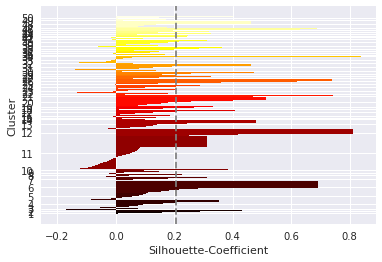

In [345]:
kmeans = MiniBatchKMeans(n_clusters=50)

ykm = kmeans.fit_predict(X_train)

silhouette_plot(X_train[:5000], ykm[:5000])

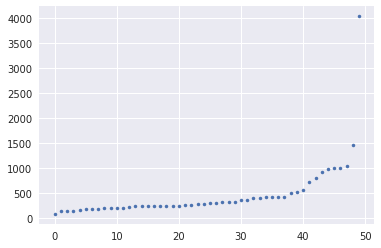

In [346]:
# number of values per cluster: follows 20:80 rule
plt.plot(sorted(Counter(kmeans.labels_).values()), '.')

2
5
10
50
100
200


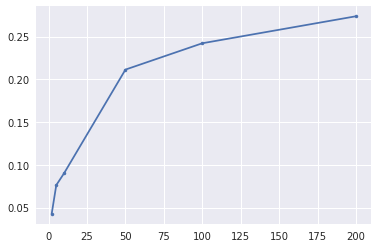

In [347]:
# data cluster badly
elbow_plot(X_train[:5000], MiniBatchKMeans, startend=[2, 5, 10, 50, 100, 200])

[ 0.04680719  0.06256255]


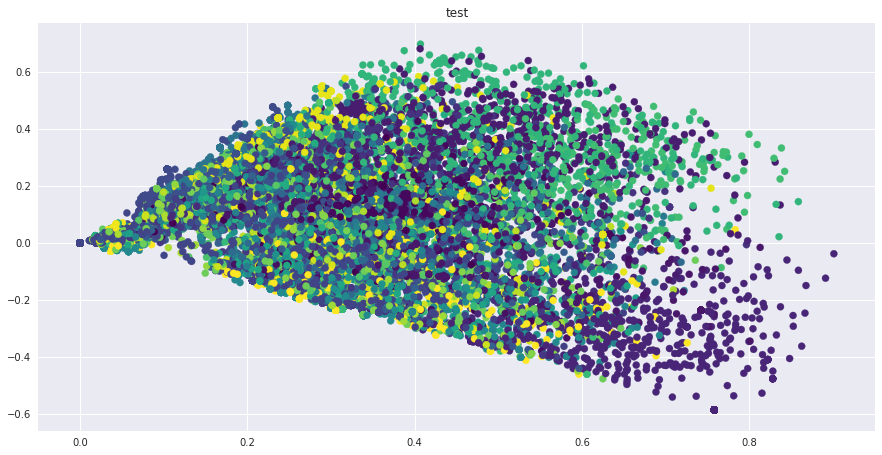

In [348]:
twod_plot(X_train, ykm, title='test')

[ 0.04680713  0.06256128  0.04995212]


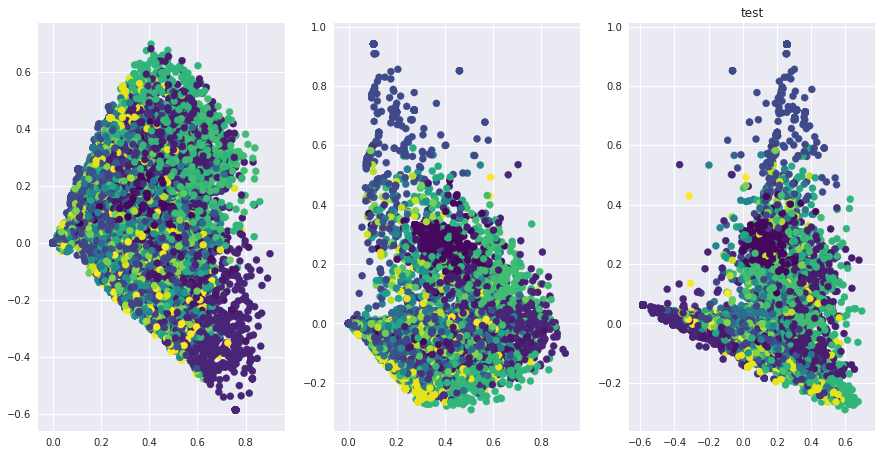

In [349]:
threed_subplots(X_train, ykm, title='test')

[ 0.04680715  0.06256255  0.04995237]


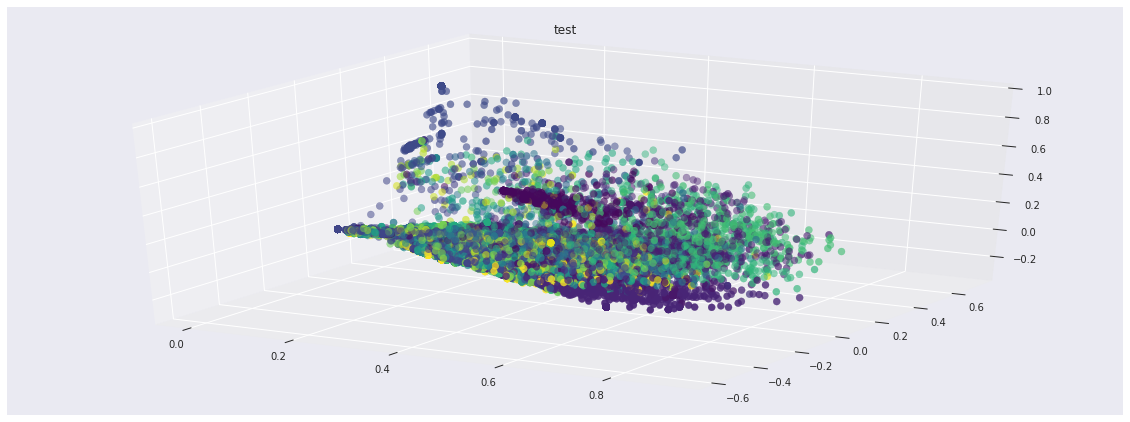

In [350]:
threed_plot(X_train, ykm, title='test')

In [351]:
labels = kmeans.labels_

C = Counter(labels)
print(sorted(C.items(), key=lambda x: x[1]))

[(33, 82), (27, 139), (18, 144), (46, 150), (42, 166), (36, 173), (15, 187), (31, 189), (24, 200), (43, 207), (2, 207), (13, 208), (0, 230), (48, 231), (41, 232), (45, 238), (38, 239), (14, 240), (35, 241), (40, 243), (20, 250), (21, 252), (9, 263), (44, 281), (34, 284), (17, 305), (7, 307), (28, 314), (49, 329), (29, 330), (8, 364), (26, 370), (1, 391), (6, 398), (22, 416), (37, 419), (25, 423), (23, 430), (16, 495), (39, 519), (30, 552), (32, 723), (47, 798), (4, 919), (3, 982), (19, 998), (12, 1007), (11, 1047), (5, 1455), (10, 4041)]


In [365]:
df_user['labels'] = labels

df_user[df_user['labels'] == 10].head() # (10, 4041)

,clean_text,tags,tweet_count,labels
user_id,,,,
1000027740815482881,Das Gesundheitssystem krankt an allen Ecken und Enden Aerzteregresse muessen fallen Heilmittelerbringer brauchen ein Sof,"Ärzteregresse, Sof",1,10
1000031402216259586,Was hier wirklich vor sich geht ist folgendes Hier sind Leute die gleich Ruecktritte Ausschluesse fordern die die AfD eh hassen Da ist der Grund egal Es geht n...,. . . . . . .,8,10
1000043230870867969,Jetzt bin ich aber gespannt wie euer Plan aussieht Was wollt ihr gegen den Pflegenotstand machen Wie sieht gute,"Pflegenotstand, gute",1,10
1000052787282104321,Das Gesundheitssystem krankt an allen Ecken und Enden Aerzteregresse muessen fallen Heilmittelerbringer brauchen ein Sof,"Ärzteregresse, Sof",1,10
1000253026039468034,Demo am 15 August in Magdeburg abgesagt Nach hitzigen Debatten haben sich Physio Deutschland und VPT heute in einem . Das Gesundheitssystem krankt an allen E...,". Ärzteregresse, Sof",2,10


In [366]:
df_user[df_user['labels'] == 5].head() # (5, 1455)

,clean_text,tags,tweet_count,labels
user_id,,,,
1000088053602439168,Germany Mayors of Cologne Bonn and Duesseldorf want to take in more migrants AfD demands immediate resignation from them h,,1,5
1000235541252788224,Die AfD warnt vor sexuellen Uebergriffen in Freibaedern Es sei denn sie gehen von weissen Maennern aus dann sollen sich die,AfD,1,5
1000257614507278336,Linksextreme veroeffentlichten eine Liste mit 134 Adressen von AfD Bueros sowie 124 Privatadressen von AfD Politikern . Die linke Idee des angeblichen strukturellen ...,AfD. Rassismus,2,5
1000362624872321025,Ich sprach von den Teilnehmer am Hess Marsch aber wenn du dir den Schuh anziehst bitte . Ach so die AFD Waehler laufen da mit ich haette es mir ja denken ...,". . . . . AfDwirkt, Thüringen, SachsenAnhalt, cottbus, Sachsen, Pegida. . .",9,5
1000510254503821318,Auslaenderfeindlich siehe Boateng nicht als Nachbar Dieser Spruch ist kein Einzelfall . Fatal ist deine Argumentation Unbedacht koennen sie nicht sein sonst wuerden s...,. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Wehrpflicht,34,5


In [367]:
df_user[df_user['labels'] == 11].head() # (11, 1047)

,clean_text,tags,tweet_count,labels
user_id,,,,
1000010209719390208,Gros fdp einLink,,1,11
1000022622,Fdp j suis mort,,1,11
1000090821474115584,Fdp detected,,1,11
1000836130311430145,Fdp d Antoine,,1,11
1001175504416845824,Kann man so interpretieren Oder einfach er hatte damals schon null Bock auf Dienst an der Waffe hat aber zu spaet verweigert Easy as that Merkt man an der SPD ...,. . . . . .,7,11


In [368]:
df_user[df_user['labels'] == 33].head() # (33, 82)

,clean_text,tags,tweet_count,labels
user_id,,,,
1006767953533194241,Afd und Antifa sind beide bescheuert,,1,33
1006963520959860737,Die Antifa ist hochgradig linksextrem Ich bin gegen Faschismus aber deshalb kein Anhaenger politischer Gewalt Und inwiefern haengt das mit meiner Nationalitaet zu...,. Neuer,2,33
1010619049028521984,Antifa ruft zu lebensgefaehrlichem Terror gegen AfD Politiker auf und veroeffentlicht Privatadressen einLink . Das kann jeder gemalt haben vorallem die Linke und Antifa,.,2,33
1017469297495560193,Ich frage mich nur woher erhalten die Gruenen 15 gibt es wirklich so viele Traumtaenzer in unserem Land Die Gruenen Klugscheisser haben ausser Multikulti und Kraftwerk...,. . . . . . . . . . . . . . .,16,33
104595541,Antifa roept op aanslagen te plegen op AfD politici en maakt hun prive adressen openbaar Hier in NL heten die mafkezen,,1,33


In [369]:
df_user[df_user['labels'] == 27].head() # (27, 139)

,clean_text,tags,tweet_count,labels
user_id,,,,
1007019423100735488,Wir sind nicht im Krieg wir sind in der Stadt Essen denn sie ordert nun 128 kugelsichere Westen fuer die Auslaenderbehoerde . Macht nur weiter so mit Eurer Hass...,Essen. AfD. .,4,27
1010840134219128832,Interview mit Franziska Schreiber ueber ihr Buch Inside AfD einLink . Kann nicht glauben dass 17 unserer Mitmenschen in Deutschland das alles wollen einLink,.,2,27
1012350472072716290,Reminder Auch wir sind beim DAYORANGE am 4 8 dabei Wir werden schon morgen ab 17 Uhr im AZ konkrete Aktionen vorbereiten un . Wer ist eigentlich diese Wir s...,DAYORANGE.,2,27
1020839756031234048,AfD bei 17 Wenn das kein Grund zur Freude ist . Heisser Sex mit Sibel Schick Das will ich Das bin ich die linke Sau,.,2,27
1023422405874733058,Griechenland wird wohl einen neuen Kredit erhalten Irgendwann kommt man vor allem bestimmt Frau Merkel aus die Idee eines Schuldenerlasses fuer Griechenland Das wird dan...,. . .,4,27


In [370]:
df_user[df_user['labels'] == 18].head() # (18, 144)

,clean_text,tags,tweet_count,labels
user_id,,,,
1001889827002994688,Es gibt ein paar pedophile bei der SPD Macht das die Partie pedophil Nur weil ein paar der AfD extrem recht sind heisst es nicht dass alle so sind . Schaemen ...,. .,3,18
101278134,wuerde auch nicht behaupten wollen dass die AfD tolle Konzepte liefert besteht aber mit allen LIBERALEN darauf dass jeder alles denken sagen und schreiben darf Me...,"Meinungsfreiheit. Merkels, Migranten, Politik, CDU, SPD. Flüchtlingskrise, Kirche, Asylbewerber, Deutschland. Merkels, Migranten, Politik, CDU, SPD. . . Merkels, Migranten, Politik, CDU, SPD.",8,18
1016415288265531392,Erneute Griechenland Rettung ueber 40 55 Milliarden Euro gegen die Stimmen der AfD beschlossen Der Haushaltsausschuss . Solche Dinge sagen sich leicht aus Wohnungen ...,. . . .,5,18
1103704003,Nicht dass ich den Artikel in irgendeiner Form verteidige aber gerade die CSU hat in letzter Zeit schon ein paar fragwuerdige Einstellungen an den Tag gelegt hust po...,,1,18
1124648551,Meine linke Timeline seit ein paar Wochen einLink,,1,18


In [363]:
# Extract the top terms per cluster

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
clusters= {}

for i in range(50):
    clusters[i] = []
    for ind in order_centroids[i, :10]:
        if i not in clusters:
            clusters[i].append('{}'.format(terms[ind]))
        clusters[i].append('{}'.format(terms[ind]))

user_cluster = pd.DataFrame.from_dict(clusters)
user_cluster.to_csv('../Data/user_cluster.csv') 

In [364]:
user_cluster.loc[:, 0:20]

,0,1,2,3,4,...,16,17,18,19,20
0,europa,staerker fdp,politiker,fuer,cdu csu,...,csu,rekordhoch,paar,gruene,ard deutschlandtrend
1,fuer,fdp linke,afd politiker,afd,cdu,...,fuer,afd rekordhoch,fuehrung,fuer,ard
2,afd,staerker,afd,fuer afd,csu,...,afd,rekordtief,cdu,linke,29
3,deutschland,deutschlandtrend,antifa,deutschland,spd,...,sieht,rekordtief afd,afd,afd,deutschlandtrend
4,afd fordert,fdp,linke,deutsche,gruene,...,klar,afd,gruene,hamburg,17
5,fordert,linke,stauffenberg,linke,afd,...,spd,deutschlandtrend,klimawandel,klimawandel,cdu csu
6,fluechtlinge,ard deutschlandtrend,fuer,fordert,linke,...,deutschland,cdu,spd,15,csu
7,parteien,afd,spd,eigentlich,fuer,...,ueber,cdu csu,linke,ueber,cdu
8,csu,ard,land,land,ard,...,migranten,union,eu,gruenen,afd
9,linke,wert,via,politik,fdp,...,waehlen,csu,wehrpflicht,links,spd


# Also use entities: 

In [382]:
import spacy

nlp = spacy.load('de')

user_ent = user_data.loc[:, ['user_id', 'clean_text']]
user_ent.groupby(user_ent['user_id'])['clean_text'].apply(lambda x: nlp(x).ents)

TypeError: Argument 'string' has incorrect type (expected str, got Series)

### LDA

In [371]:
cv = CountVectorizer(stop_words=stopwords_de,
                    max_df=.1,
                    max_features=5000)

X_LDA = cv.fit_transform(all_data.loc[:, 'clean_text'])

In [374]:
lda = LatentDirichletAllocation(n_components=20,
                               random_state=123,
                               learning_method='batch')

X_lda_topics = lda.fit_transform(X_LDA)

In [375]:
n_top_words = 5
feature_names = cv.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print('Topic {}'.format(topic_idx + 1))
    print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:-1]]))

Topic 1
ard deutschlandtrend fdp staerker rekordwert
Topic 2
seehofer liebe bitte regierung politiker
Topic 3
18 15 sonntagsfrage bundestagswahl 17
Topic 4
frau letzten deutschen 13 klar
Topic 5
buerger essen rechtsstaat bilder sieht
Topic 6
fdp prozent wert deutschlandtrend staerker
Topic 7
fdp verstehe sackt allzeittief gefaellt
Topic 8
wehrpflicht weiss danke noafd politiker
Topic 9
ueber weisse medien egal rassismus
Topic 10
fluechtlinge kommentar europa welt goering
Topic 11
bayern prozent seehofer umfrage laeuft
Topic 12
politik rekordtief union merkel rekordhoch
Topic 13
ever at worst all 17
Topic 14
einfach deutschland genau problem land
Topic 15
waere bremen muessen derzeit 24
Topic 16
aufstehen sammlungsbewegung wagenknecht sieht polizei
Topic 17
partei waehlen wuerde finde rechts
Topic 18
000 terror antifa deutschen 15
Topic 19
duerfen ueber gruen waehler rot
Topic 20
gruenen fordert geld gauland deutschen


In [381]:
topic = X_lda_topics[:, 4].argsort()[::-1]
for iter_idx, topic_idx in enumerate(topic[:50]):
    print('Tweet: ')
    print(user_data['clean_text'][topic_idx])

Tweet: 
   Erneute  Griechenland   Rettung   ueber  40  55  Milliarden  Euro  gegen  die  Stimmen  der  AfD  beschlossen   Der  Haushaltsausschuss  
Tweet: 
   Erneute  Griechenland   Rettung   ueber  40  55  Milliarden  Euro  gegen  die  Stimmen  der  AfD  beschlossen   Der  Haushaltsausschuss  
Tweet: 
   Erneute  Griechenland   Rettung   ueber  40  55  Milliarden  Euro  gegen  die  Stimmen  der  AfD  beschlossen   Der  Haushaltsausschuss  
Tweet: 
   Erneute  Griechenland   Rettung   ueber  40  55  Milliarden  Euro  gegen  die  Stimmen  der  AfD  beschlossen   Der  Haushaltsausschuss  
Tweet: 
   Erneute  Griechenland   Rettung   ueber  40  55  Milliarden  Euro  gegen  die  Stimmen  der  AfD  beschlossen   Der  Haushaltsausschuss  
Tweet: 
   Erneute  Griechenland   Rettung   ueber  40  55  Milliarden  Euro  gegen  die  Stimmen  der  AfD  beschlossen   Der  Haushaltsausschuss  
Tweet: 
   Erneute  Griechenland   Rettung   ueber  40  55  Milliarden  Euro  gegen  die  Stimmen  der  Af